In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from lstm_policy import pad_and_concat
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF

In [3]:
import tensorflow as tf

BATCH_SIZE = 64

sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('models/activepolicy-18-03-19-001439/model-1000064.meta')
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint('./models/activepolicy-18-03-19-001439/.'))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ./models/activepolicy-18-03-19-001439/./model-1000064


In [4]:
g_inputs = graph.get_tensor_by_name("inputs:0")
g_lengths = graph.get_tensor_by_name("lengths:0")

In [5]:
g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [6]:
np.set_printoptions(precision=3, suppress=True)

In [34]:
inputs = np.asarray([[[1, 2, 3], [1, 2, -3], [1, -2, 3], [1, -2, -3]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])

0.9999999 [1.    0.996 1.    0.958 1.    0.933 0.    0.    0.009 0.001]


In [27]:
# Because we have to pass full batch
ALMOST_EMPTY_CNFS = [CNF([[1, 2, 3], [-1, -2, 3]]) for i in range(BATCH_SIZE-1)]

class LSTMBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        cnfs = [input_cnf] + ALMOST_EMPTY_CNFS
        cnfs_clauses = [[claus + tuple([0] * (3-len(claus))) for claus in cnf.clauses] for cnf in cnfs]
        inputs, lengths = pad_and_concat(cnfs_clauses)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs, g_lengths: lengths})
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][(var-1)*2 + (0 if svar > 0 else 1)]
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        return svar

In [11]:
def compute_steps(sats, dpll_cls):
    steps = []
    for sat in sats:
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
    return steps

In [12]:
def compute_and_print_steps(sats, dpll_cls):
    steps = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {}; stdev step: {}".format(
        len(steps), np.mean(steps), np.std(steps)))
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=range(2**(N+1)))
    plt.show()

In [18]:
def print_all(s, k, n, m):
    global S, K, N, M
    S = s
    K = k
    N = n
    M = m
    
    MAX_TRIES = 10000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_random_kcnf(K, N, M)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, LSTMBasedDPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)

#Sats: 400; avg step: 3.7525; stdev step: 1.1688642992238234


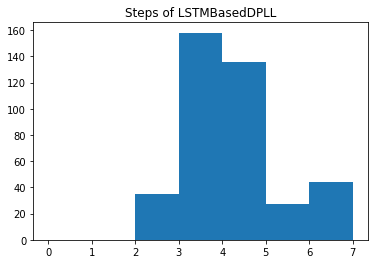

#Sats: 400; avg step: 3.85; stdev step: 1.2932517156377563


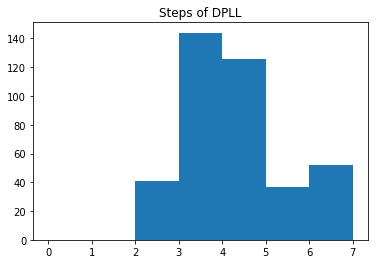

#Sats: 400; avg step: 3.7475; stdev step: 1.1720681507489228


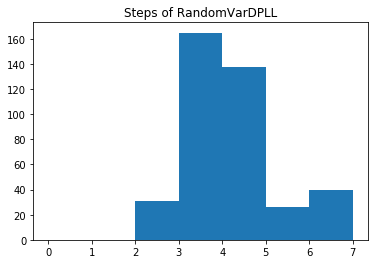

#Sats: 400; avg step: 3.0225; stdev step: 0.7790980361931354


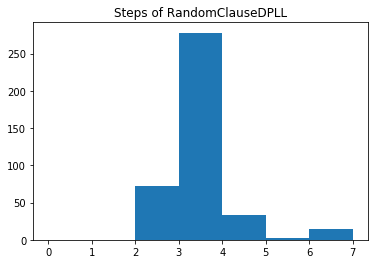

#Sats: 400; avg step: 2.695; stdev step: 0.4816378307400696


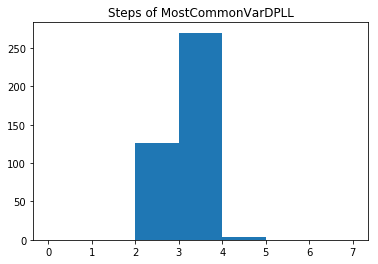

In [14]:
print_all(400, 2, 2, 3)

#Sats: 400; avg step: 4.3775; stdev step: 1.5362271153706408


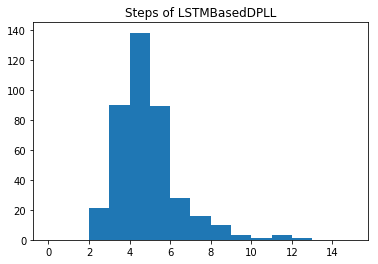

#Sats: 400; avg step: 4.4; stdev step: 1.5394804318340654


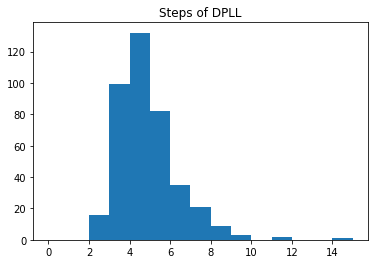

#Sats: 400; avg step: 4.5325; stdev step: 1.599669887820609


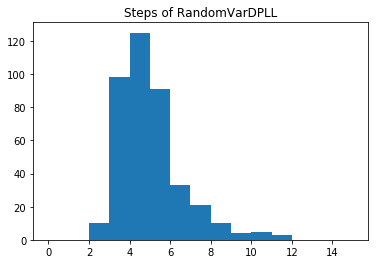

#Sats: 400; avg step: 3.22; stdev step: 0.7222188034107115


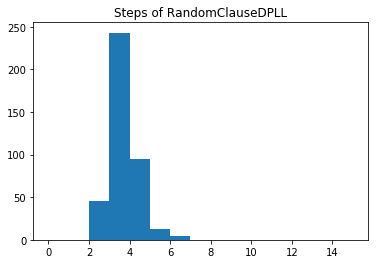

#Sats: 400; avg step: 2.915; stdev step: 0.5681329069856806


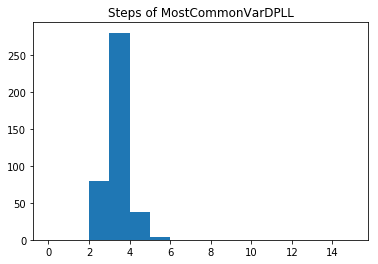

In [15]:
print_all(400, 2, 3, 3)

#Sats: 400; avg step: 4.9275; stdev step: 1.828180447877069


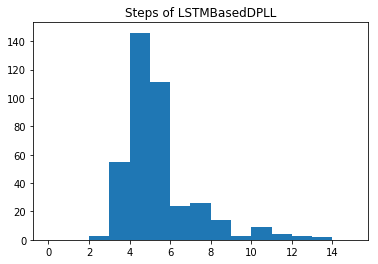

#Sats: 400; avg step: 4.8575; stdev step: 1.7326839729160075


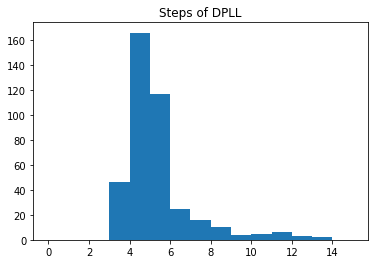

#Sats: 400; avg step: 5.0675; stdev step: 1.8676037454449483


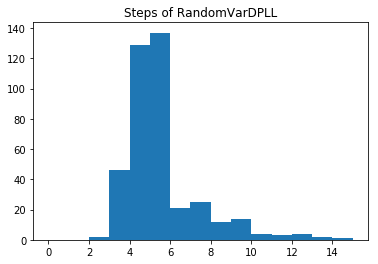

#Sats: 400; avg step: 3.94; stdev step: 1.3177253128023307


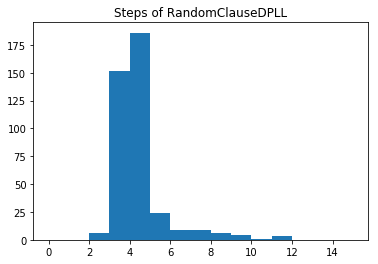

#Sats: 400; avg step: 3.2975; stdev step: 0.6625660344448696


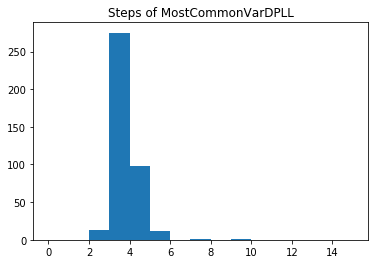

In [16]:
print_all(400, 3, 3, 6)

#Sats: 100; avg step: 14.22; stdev step: 8.167716939267669


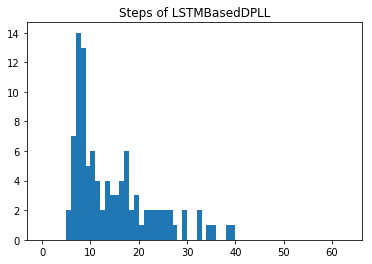

#Sats: 100; avg step: 14.22; stdev step: 7.297369389033284


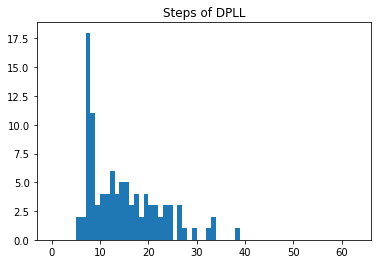

#Sats: 100; avg step: 13.16; stdev step: 6.85378727420103


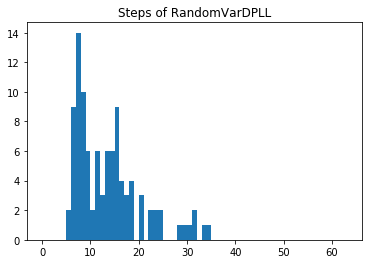

#Sats: 100; avg step: 11.81; stdev step: 6.489522324485831


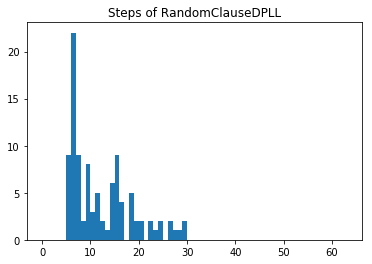

#Sats: 100; avg step: 7.46; stdev step: 3.795839828022252


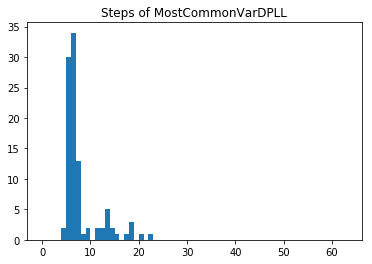

In [17]:
print_all(100, 3, 5, 20)